# ICLR Data Processing


v0.1 Jiayao Zhang
June 14, 2023

In [5]:
from __future__ import print_function, absolute_import, division
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import pandas as pd
import tqdm
import json
import uuid
import sqlite3
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

sns.set()
sns.set(font_scale=2.5,)
sns.set_style("white")
# sns.set_style({'font.family': 'Libertine'})
sns.set_palette("colorblind")


plt.rcParams.update({'font.size': 20, 'lines.linewidth':4, 'lines.markersize':12, 
                         'xtick.labelsize':15, 'ytick.labelsize':15, 'axes.labelsize':20,
                         'axes.titlesize': 20, 'legend.fontsize':20,
                         'pdf.fonttype': 42, 'ps.fonttype':42, 
                        'image.interpolation':'nearest', 'figure.figsize': (10,8),
                     "text.usetex": False,
         'text.latex.preamble': r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
                     
                    })
tqdm.tqdm.pandas()


## Load Data

### ICLR Database

See (ICLR Datbse)[https://cogcomp.github.io/iclr_database/] for details of getting the data.

In [7]:
import src.utils as utils
import src.data_utils as data_utils
DATA_PATH = Path('/shared/zjiayao/exp_db')
DB_NAME = "cs_conf_release.db"


In [8]:
db_con = sqlite3.connect(DATA_PATH/DB_NAME)
dataloader = data_utils.DataLoader(db_con, None)

In [10]:
# load tables
sub_reviews_agg = dataloader.get_table('sub_reviews_agg')
sub_derive = dataloader.get_table('sub_derive')
sub_arxiv=dataloader.get_table('submission_arxiv')
author_grp = dataloader.get_table('author_grp')



In [330]:
dataloader.get_table('venues').to_csv('venues.csv',header=True,index=False)

In [327]:
sub_reviews_agg.groupby('year').full_decision.unique()

year
2017    [Reject, Accept (Poster), Invite to Workshop T...
2018    [Accept (Poster), Reject, Invite to Workshop T...
2019             [Reject, Accept (Poster), Accept (Oral)]
2020    [Accept (Poster), Accept (Spotlight), Reject, ...
2021    [Reject, Accept (Poster), Accept (Oral), Accep...
2022    [Reject, Accept (Oral), Accept (Poster), Accep...
Name: full_decision, dtype: object

In [30]:
# aggregate the "design matrix"
design_mat = (sub_reviews_agg # submission-review features
 .merge(sub_derive, on=['submission_id','year']) # derived features from submissions
 .merge(author_grp, on=['submission_id','year','arxiv_first']) # arXiv features
)

# merge with Specter embeddings
# https://www.dropbox.com/s/4cmpoftztj8ajyl/submission_cluster_20.csv?dl=1
design_mat = (design_mat
    .merge(pd.read_csv(DATA_PATH / 'submission_cluter_20.csv')[['submission_id','cluster']],
           on='submission_id', how='left')
)

In [ ]:
# internal use only
baby_iclr=(design_mat[['submission_id','year','full_decision','arxiv_first',]]
 .merge(subs[['submission_id','title','authors','keywords','tldr']],
       on='submission_id',how='left')
 .merge(sub_arxiv[['submission_id','arxiv_id','primary_category',
                  'published_time','updated_time']], on='submission_id', how='left')
)

### S2 Citation Data (NCO)

In [740]:
# here the example is 1-year, 3-year, and 5-year (dropping NA rows)
# change the path accordingly
import functools
citation_data_path = [
#     ('c365', './c_365.tsv', '\t'),
    ('c730', './c_730.tsv', '\t')
#     ('c1095', './c_1095.tsv', '\t'),
#     ('c1825', './c_1825.tsv', '\t')

]

cites_within_window = functools.reduce(
    lambda x,y: x.merge(y,on=['submission_id'], how='outer'),
    [(pd.read_csv(p, sep=s)
      .rename({'cites_within_year':l,'cites_within_window':l},axis=1,errors='ignore')
      [['submission_id',l]]
     )
     for l, p, s in citation_data_path],
)


In [741]:
design_mat = design_mat.merge(cites_within_window, on='submission_id', how='outer')

In [802]:
design_mat['log_n_tweets']=np.log10(1+design_mat['n_tweets'])

<AxesSubplot:xlabel='log_n_tweets', ylabel='Count'>

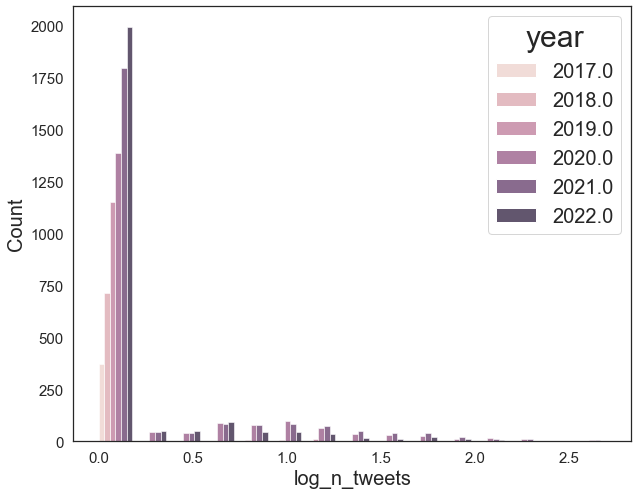

In [803]:
sns.histplot(data=design_mat,x='log_n_tweets', hue='year',multiple='dodge')

## Prepare Data for Matching

In [78]:
# log transform some columns
design_mat['log_input_len'] = np.log10(design_mat['input_len'])
design_mat['log_ins_rank_min'] = np.log10(design_mat['ins_rank_min'])
design_mat['log_ins_rank_avg'] = np.log10(design_mat['ins_rank_avg'])
design_mat['log_ins_rank_max'] = np.log10(design_mat['ins_rank_max'])
design_mat['log_author_cite_max'] = np.log10(1+design_mat['author_cite_max'])
design_mat['log_author_cite_avg'] = np.log10(1+design_mat['author_cite_avg'])
design_mat['log_author_cite_min'] = np.log10(1+design_mat['author_cite_min'])

In [79]:
Ns = ['c365', 'c1095', 'c1825']
A = 'arxiv_first'
Y = 'binary_decision'
C_cols = ['year',
 'log_input_len',
 'log_n_tweets',
 'n_fig',
 'n_ref',
 'n_sec',
 'sub_fluency',
 'cluster',
 'n_author',
 'fst_reported_f',
 'any_reported_f',
 'cnt_reported_f',
 'demo_no_us',
 'log_ins_rank_min',
 'log_ins_rank_avg',
 'log_ins_rank_max',
 'log_author_cite_min',
 'log_author_cite_avg',
 'log_author_cite_max'
]

C_vars = ['C(year)',
 'log_input_len',
 'log_n_tweets',
 'n_fig',
 'n_ref',
 'n_sec',
 'sub_fluency',
 'C(cluster)',
 'n_author',
 'C(fst_reported_f)',
 'C(any_reported_f)',
 'cnt_reported_f',
 'C(demo_no_us)',
 'log_ins_rank_min',
 'log_ins_rank_avg',
 'log_ins_rank_max',
 'log_author_cite_min',
 'log_author_cite_avg',
 'log_author_cite_max'
]

In [99]:
## remove NAs in covariates
design_mat = design_mat[~design_mat[C_cols].isna().any(axis=1)]

In [100]:
design_mat.to_csv('./design_mat.csv',header=True,index=False)

In [103]:
## (optional) create cosine-similarity matrix
# emb_df = pd.read_csv(DATA_PATH / 'submission_specter_embedding.csv')
# utils.lit_eval_df(emb_df, ['encoded_vec'])

In [160]:
## load back matched df

In [162]:
def load_matched_df(path, df):
    matched_design_mat = pd.read_csv(path).drop('Unnamed: 0',axis=1)
    matched_design_mat=matched_design_mat[~matched_design_mat.matched_set.isna()]
    return pd.concat([
        matched_design_mat.iloc[::2].assign(grp='treated'),
        matched_design_mat.iloc[1::2].assign(grp='control'),]
    )

#### Matched Data
1. https://www.dropbox.com/s/1y75t3mw6a70aj1/fb_matched_design_mat_ordered.csv?dl=0
2. https://www.dropbox.com/s/4fl3wa4wq15zqwr/matched_design_mat_ordered.csv?dl=0

In [352]:
## without fine-balance
matched_dat = load_matched_df('matched_design_mat_ordered.csv', design_mat)

## with fine-balance
fb_matched_dat = load_matched_df('fb_matched_design_mat_ordered.csv', design_mat)

In [473]:
cluster_df = design_mat.groupby('cluster').apply(lambda s: 
    s.groupby('primary_keyword').size().sort_values(ascending=False).iloc[:5],

                                   ).to_frame('count').reset_index()

In [488]:
for i in range(20):
    print(cluster_df[cluster_df.cluster==i])

   cluster         primary_keyword  count
0        0  reinforcement learning     18
1        0           meta-learning     17
2        0           deep learning     13
3        0   unsupervised learning     11
4        0              robustness     10
   cluster                     primary_keyword  count
5        1              reinforcement learning    116
6        1                       deep learning     47
7        1             representation learning     11
8        1  model-based reinforcement learning     10
9        1                     computer vision      9
    cluster                primary_keyword  count
10        2                  deep learning     31
11        2              generative models     13
12        2  convolutional neural networks      8
13        2         reinforcement learning      8
14        2        representation learning      7
    cluster            primary_keyword  count
15        3              deep learning     57
16        3  recurrent neural ne

### Table One

In [491]:
design_mat=pd.read_csv('./design_mat.csv')

In [147]:
import tableone
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [407]:
def constrcut_tableone(matched, df):
    return tableone.TableOne(pd.concat([matched,
                                      df[~df.arxiv_first].assign(grp='unmatched')]
                            )[C_cols+['grp']].reset_index(), #.assign(grpi=lambda s:s['grp']).set_index(['grpi','submission_id']),
                           categorical=['cluster','demo_no_us','fst_reported_f', 'any_reported_f'],
                           groupby=['grp'],overall=False, smd=True, missing=False,
                           order={'cluster':range(20)},
#                              rename={'control':'Matched Comparison Articles', 'treated': 'Early arXiv\'ed Papers',
#                                     'unmatched': 'Non-Early arXiv\'ed Papers'},
                           pval=False
    )

In [492]:
t1_fb_matched = constrcut_tableone(fb_matched_dat,design_mat).tableone

In [493]:
t1_fb_matched.columns=t1_fb_matched.columns.get_level_values(1)


In [494]:
pd.concat([fb_matched_dat,
            design_mat[~design_mat.arxiv_first].assign(grp='unmatched')]
    )[C_cols+['grp']].groupby('grp').size()

grp
control      1486
treated      1486
unmatched    7493
dtype: int64

In [353]:
t1_matched = constrcut_tableone(matched_dat,design_mat)

t1_fb_matched = constrcut_tableone(fb_matched_dat,design_mat)

In [495]:
t1_fb_matched_print=(t1_fb_matched[[t1_fb_matched.columns[i] for i in [1,2,0,3,5]]]
  .rename({'control':'Matched Comparison Articles', 
          'treated': 'Early arXiv\'ed Papers (Treated Group)',
            'unmatched': 'Non-Early arXiv\'ed Papers (Unmatched)',
           'SMD (treated,unmatched)': 'SMD (Before Matching)',
           'SMD (control,treated)': 'SMD (After Matching)',
          },axis=1
        )
)

In [496]:
def rename_index(s):
    s = list(s)
    s[0] = r"\texttt{" + s[0].split(',')[0].replace('_','\_')+r"}"
    return tuple(s)

In [497]:
t1_fb_matched_print.index=t1_fb_matched_print.index.map(rename_index)

In [498]:
print(t1_fb_matched_print.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
                                &      & Early arXiv'ed Papers (Treated Group) & Non-Early arXiv'ed Papers (Unmatched) & Matched Comparison Articles & SMD (Before Matching) & SMD (After Matching) \\
\midrule
\texttt{n} & {} &                                  1486 &                                  7493 &                        1486 &                       &                      \\
\texttt{index} &      &                        1485.0 (858.2) &                       4447.8 (2585.8) &              1486.0 (858.2) &                 1.538 &               -0.001 \\
\texttt{year} &      &                          2020.8 (0.9) &                          2020.3 (1.5) &                2020.8 (0.9) &                -0.447 &               -0.001 \\
\texttt{log\_input\_len} &      &                             4.0 (0.2) &                             4.0 (0.2) &                   4.0 (0.2) &                -0.355 &               -0.002 \\
\texttt{n\_fig} &      &   